In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal 
import scipy.fftpack
from pylab import *
from scipy import pi
import pylab
import cmath
import sys
import tensorflow as tf
import lvm_read
print(tf.__version__)

2.0.0-rc0


In [10]:
data_path = "/media/yukun/2C167E66167E30C6/AE_data/20180104 正常砂輪研磨/第一次研磨(過負載)/"
# Import DATA
no = 30
url = data_path + "AEdate_"+str(no)+".lvm"

dt_loading = pd.read_fwf(url, widths=[10])[21:5000021] # samples : 4999168 (1024 * 4882) (2^22 = 4194304)
dt_tartype = np.array(dt_loading, dtype = np.float32) 
# print(type(dt_tartype))
#ae_rawdata = pd.DataFrame(dt_tartype)#[0:4999168]
#ae_rawdata = dt_tartype.flatten()
ae_rawdata = dt_tartype.ravel()

# show the raw signal data
print(ae_rawdata)

[-0.119629 -0.236816 -0.288086 ...  0.144043 -0.493164 -0.822754]


ae data sample rate :5000000


Text(0, 0.5, 'volt')

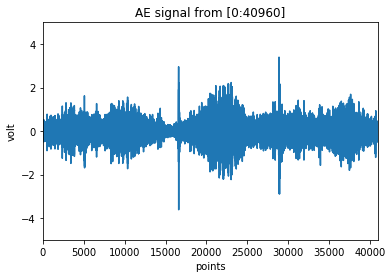

In [11]:
# show the raw signal plot
ae_data = ae_rawdata - ae_rawdata.mean()

sample_rate = len(ae_data)
print("ae data sample rate :{0}".format(sample_rate))

plt.plot(range(40960), ae_data[:40960])
plt.xlim(0,40960)
plt.ylim(-5,5)
plt.title("AE signal from [0:40960]")
plt.xlabel("points")
plt.ylabel("volt")

In [12]:
ae_max = np.max(np.abs(ae_data))
ae_min = np.min(np.abs(ae_data))
print("Maxima AE data: {0}".format(ae_max))
print("Minima AE data: {0}".format(ae_min))

Maxima AE data: 5.152009963989258
Minima AE data: 0.0006417930126190186


## STFT

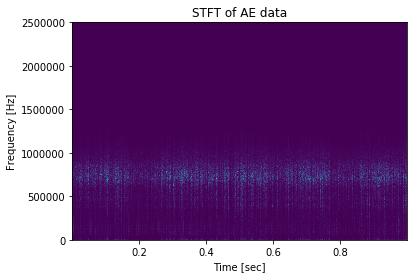

STFT factor shape f : (2049,)
STFT factor shape t : (2440,)
STFT factor shape Sxx : (2049, 2440)


In [13]:
window_size = 4096
[f,t,Sxx]=signal.spectral.spectrogram(x = ae_data[:],
                                    fs = sample_rate,
                                    window = np.hamming(window_size),
                                    nperseg = window_size,
                                    noverlap = window_size // 2,
                                    nfft = None,
                                    detrend = False,
                                    return_onesided = True,
                                    mode = 'magnitude')
# plt.pcolormesh(t, f, Sxx)
plt.pcolormesh(t, np.fft.fftshift(f[:]), np.fft.fftshift(Sxx[:,:], axes=0))
plt.title("STFT of AE data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

print("STFT factor shape f : {0}".format(shape(f)))
print("STFT factor shape t : {0}".format(shape(t)))
print("STFT factor shape Sxx : {0}".format(shape(Sxx)))

1024 point of frequency to AE STFT shape:  (1024, 2440)


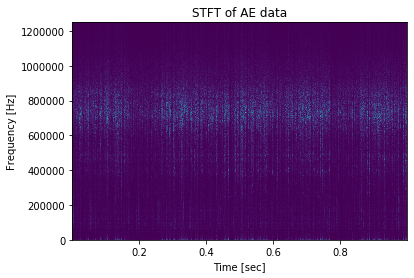

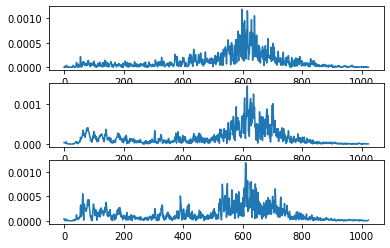

In [14]:
print('1024 point of frequency to AE STFT shape: ', format(Sxx[:1024].shape))
plt.pcolormesh(t,f[:1024],Sxx[:1024])
plt.title("STFT of AE data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.figure()
plt.subplot(3,1,1)
plt.plot(Sxx[:1024,0])
plt.subplot(3,1,2)
plt.plot(Sxx[:1024,1])
plt.subplot(3,1,3)
plt.plot(Sxx[:1024,2])
plt.show()

In [ ]:
# Normalization STFT coefficient
ae_stft_nor = Sxx / np.max(Sxx)

In [ ]:
window_size = 4096
ae_ = ae_data.astype(float32)
stft = tf.signal.stft(
         ae_,
         window_size,
         frame_step=window_size//2,
         fft_length=None,
         window_fn=tf.signal.hann_window,
         pad_end=False,
         name=None
)
stft_ = stft[:,:1024]
stft_.shape


# plt.pcolormesh(t, np.fft.fftshift(f), np.fft.fftshift(Sxx, axes=0))
# plt.title("STFT of AE data")
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

# print("STFT factor shape f : {0}".format(shape(f)))
# print("STFT factor shape t : {0}".format(shape(t)))
# print("STFT factor shape Sxx : {0}".format(shape(Sxx)))

In [ ]:
# get AE data start date
dt_get_date = pd.read_fwf(url, widths=[20])[8:9]
dt_datetype = np.array(dt_get_date, dtype = np.str_)[0]
# print(dt_datetype[0][5:])
# get AE data start time
dt_get_time = pd.read_fwf(url, widths=[13])[14:15] # samples : 4999168 (1024 * 4882) (2^22 = 4194304)
dt_timetype = np.array(dt_get_time, dtype = np.str_)[0]
# print(dt_timetype[0][5:])

dt_start_datatime = dt_datetype[0][5:]+' '+ dt_timetype[0][5:]
print('data mask date and time : {0}'.format(dt_start_datatime))

(2440, 2049)
(2049, 2440, 1)


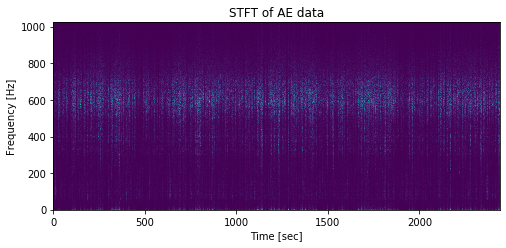

In [17]:
stfts =tf.signal.stft(
    ae_data[:].astype(np.float32), 4096, 2048, fft_length=4096,
    window_fn=tf.signal.hann_window, pad_end=False, name=None
)
print(shape(stfts))
stfts2 = np.expand_dims(stfts, axis=0)
print(shape(stfts2.T))
power_spectrograms = tf.math.real(stfts * tf.math.conj(stfts))
magnitude_spectrograms = tf.abs(stfts)
mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
plt.figure(figsize=(8,5))
plt.imshow(tf.transpose(magnitude_spectrograms[:,:1024]), origin='lower')
plt.title("STFT of AE data")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [103]:
type(mag_stft)

tensorflow.python.framework.ops.EagerTensor

## Data to STFT tf.data

In [6]:
def _read_py_function(filename, label):
    dt_loading = pd.read_fwf(url, widths=[10])[21:5000021]
    dt_tartype = np.array(dt_loading, dtype = np.float_)
    ae_rawdata = dt_tartype.ravel()
    ae_data = ae_rawdata - ae_rawdata.mean()
    return ae_data, label
    

def _preprocess_function(ae_data, label):
    
    stfts =tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
        window_fn=tf.signal.hann_window, pad_end=False, name=None
        )
    magnitude_spectrograms = tf.abs(stfts)
    mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
    return mag_stft, label


In [7]:
data_path = "/media/yukun/2C167E66167E30C6/AE_data/20180104 正常砂輪研磨/第一次研磨(過負載)/"
# Import DATA
no = 30
url = data_path + "AEdate_"+str(no)+".lvm"

filenames = tf.constant([url, url])
labels = tf.constant([0, 1])

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(
    lambda filename, label: tuple(tf.py_function(
        _read_py_function, [filename, label], [tf.float32, label.dtype])))
dataset = dataset.map(_preprocess_function)

In [12]:
for data, label in dataset.take(1):
    print('x: {}'.format(data))
    print(shape(data))

x: [[4.8376012e-01 3.3054533e+00 3.6560063e+00 ... 2.0754332e+02
  2.0243636e+02 3.4957462e+01]
 [1.3667885e+00 3.4712276e+00 1.6112204e+00 ... 1.8380440e+02
  2.3359697e+02 1.9185843e+01]
 [1.9417853e+00 3.5489974e+00 1.9401510e+00 ... 2.1948882e+02
  9.2221298e+01 5.0081272e+01]
 ...
 [1.7346053e-01 4.9992266e-01 4.5908180e-01 ... 1.1246167e+00
  4.1394424e+00 9.6142554e-01]
 [2.0704588e-01 4.5745185e-01 1.1931512e+00 ... 5.2538866e-01
  4.4451137e+00 6.1637509e-01]
 [3.3751851e-01 6.4873636e-01 1.3959914e+00 ... 1.8332871e+00
  5.2468629e+00 1.7215488e+00]]
(1024, 2440)


In [32]:
print(shape(data))
a = np.array(data).T
b = np.expand_dims(a,0)
c = b.T
print(shape(c))

(1024, 2440)
(1024, 2440, 1)


## Get all using files path

In [2]:
# get want using file path
import os
from os import walk
from os.path import join

def data_path(mypath):
    filepath = []
    ae_path = []
    cu_path = []
    ae_path_container = []
    cu_path_container = []
    # 遞迴列出所有檔案的絕對路徑
    for root, dirs, files in walk(mypath):
        for f in files:
            if f.find("AEdate") >= 0: ae_path.append(f)
            elif f.find("Current") >= 0: cu_path.append(f)
#             elif f.find(".csv") >=0: equ_path = f
        ae_path.sort(key = lambda x: int(x[7:-4]))
        cu_path.sort(key = lambda x: int(x[8:-4]))
        for class_ in ae_path:
            files_path = os.path.join(root, class_)           
            ae_path_container.append(files_path)
        for class_ in cu_path:
            files_path = os.path.join(root, class_)           
            cu_path_container.append(files_path)
#         equ_path_container = equ_path
    return ae_path_container


In [3]:
# read data path
dryrun_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20190313_1113_DryRun/DryRun_1/"
dryrun_1_data = data_path(dryrun_1_path)
dryrun_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20200213_DryRun/water_on_fan/DryRun_2/"
dryrun_2_data = data_path(dryrun_2_path)
dryrun_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20200213_DryRun/water_on_wheel/DryRun_3"
dryrun_3_data = data_path(dryrun_3_path)

row0001_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1602_row0001_feed200um_1_har1/row0001_1/"
row0001_1_data = data_path(row0001_1_path)
row0001_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1630_row0001_feed200um_2_har1/row0001_2/"
row0001_2_data = data_path(row0001_2_path)
row0001_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1720_row0001_feed200um_3_har1/row0001_3/"
row0001_3_data = data_path(row0001_3_path)

row005_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20181203_1404_row005_feed300um_1_nor1/row005_1/"
row005_1_data = data_path(row005_1_path)
row005_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20181204_0900_row005_feed300um_2_nor1/row005_2/"
row005_2_data = data_path(row005_2_path)
row005_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20181207_1550_row005_feed100um_3_nor1/row005_3/"
row005_3_data = data_path(row005_3_path)

row01_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20181225_0234_row01_feed200um_1_sof3/row01_1/"
row01_1_data = data_path(row01_1_path)
row01_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20181225_0310_row01_feed200um_2_sof3/row01_2/"
row01_2_data = data_path(row01_2_path)
row01_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20181225_0350_row01_feed150um_3_sof3/row01_3/"
row01_3_data = data_path(row01_3_path)

row1_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20181227_1010_row1_feed200um_1_sof2/row1_1/"
row1_1_data = data_path(row1_1_path)
row1_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20181227_1102_row1_feed200um_2_sof2/row1_2/"
row1_2_data = data_path(row1_2_path)
row1_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20181227_1145_row1_feed200um_3_sof2/row1_3/"
row1_3_data = data_path(row1_3_path)

row3_1_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1355_row3_feed200um_1_sof1/row3_1/"
row3_1_data = data_path(row3_1_path)
row3_2_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1430_row3_feed200um_2_sof1/row3_2/"
row3_2_data = data_path(row3_2_path)
row3_3_path = "/media/yukun/2C167E66167E30C6/AEdata/20190104_1510_row3_feed200um_3_sof1/row3_3/"
row3_3_data = data_path(row3_3_path)

print('dryrun_1_data :',shape(dryrun_1_data))
print('dryrun_2_data :',shape(dryrun_2_data))
print('dryrun_3_data :',shape(dryrun_3_data))

print('row0001_1_data :',shape(row0001_1_data))
print('row0001_2_data :',shape(row0001_2_data))
print('row0001_3_data :',shape(row0001_3_data))

print('row005_1_data :',shape(row005_1_data))
print('row005_2_data :',shape(row005_2_data))
print('row005_3_data :',shape(row005_3_data))

print('row01_1_data :',shape(row01_1_data))
print('row01_2_data :',shape(row01_2_data))
print('row01_3_data :',shape(row01_3_data))

print('row1_1_data :',shape(row1_1_data))
print('row1_2_data :',shape(row1_2_data))
print('row1_3_data :',shape(row1_3_data))

print('row3_1_data :',shape(row3_1_data))
print('row3_2_data :',shape(row3_2_data))
print('row3_3_data :',shape(row3_3_data))

dryrun_1_data : (57,)
dryrun_2_data : (68,)
dryrun_3_data : (306,)
row0001_1_data : (180,)
row0001_2_data : (174,)
row0001_3_data : (168,)
row005_1_data : (200,)
row005_2_data : (201,)
row005_3_data : (101,)
row01_1_data : (200,)
row01_2_data : (200,)
row01_3_data : (152,)
row1_1_data : (200,)
row1_2_data : (201,)
row1_3_data : (200,)
row3_1_data : (202,)
row3_2_data : (200,)
row3_3_data : (201,)


In [4]:
dryrun_all = np.hstack((dryrun_1_data, dryrun_2_data, dryrun_3_data))
row0001_all = np.hstack((row0001_1_data, row0001_2_data, row0001_3_data))
row005_all = np.hstack((row005_1_data, row005_2_data, row005_3_data))
row01_all = np.hstack((row01_1_data, row01_2_data, row01_3_data))
row1_all = np.hstack((row1_1_data, row1_2_data, row1_3_data))
row3_all = np.hstack((row3_1_data, row3_2_data, row3_3_data))
print('dryrun shape:  ',dryrun_all.shape)
print('row0001 shape: ',row0001_all.shape)
print('row005 shape:  ',row005_all.shape)
print('row01 shape:   ',row01_all.shape)
print('row1 shape:    ',row1_all.shape)
print('row3 shape:    ',row3_all.shape)

dryrun shape:   (431,)
row0001 shape:  (522,)
row005 shape:   (502,)
row01 shape:    (552,)
row1 shape:     (601,)
row3 shape:     (603,)


In [5]:
ae_data_path = np.hstack((dryrun_all[0:5], row0001_all[0:5], row005_all[0:5], row01_all[0:5], row1_all[0:5], row3_all[0:5]))
print('all ae data: ',shape(ae_data_path))

# get label
ae_label=[]
files = [dryrun_all[0:5], row0001_all[0:5], row005_all[0:5], row01_all[0:5], row1_all[0:5], row3_all[0:5]]
for index in range(len(files)): 
    file_dir = files[index]   
    col = np.ones([len(file_dir),])
    ae_label.extend(col*(index))
    
ae_label = np.array(ae_label)
print('all label: ',shape(ae_label))

all ae data:  (30,)
all label:  (30,)


In [6]:
ae_val_path = np.hstack((dryrun_all[6:10], row0001_all[6:10], row005_all[6:10], row01_all[6:10], row1_all[6:10], row3_all[6:10]))
print('all ae data: ',shape(ae_val_path))

all ae data:  (24,)


In [6]:
# from sklearn.model_selection import train_test_split
# train_data , test_data , train_label , test_label = train_test_split(ae_data_path,ae_label,test_size=0.2,random_state=87)
# print('train_data shape: ',shape(train_data))
# print('train_label shape: ',shape(train_label))
# print('test_data shape: ',shape(test_data))
# print('test_label shape: ',shape(test_label))

### Preprocess data 1

In [7]:
def get_label(file):
    if file.find("DryRun") >=0: class_name=0
    elif file.find("row0001") >=0: class_name=1
    elif file.find("row005") >=0: class_name=2
    elif file.find("row01") >=0: class_name=3
    elif file.find("row1") >=0: class_name=4
    elif file.find("row3") >=0: class_name=5
    return tf.one_hot(class_name, 6)


def _read_py_function(filename, label):
    labels = get_label((filename.numpy()).decode('utf-8'))
    dt_loading = pd.read_fwf((filename.numpy()).decode('utf-8'), widths=[10])[21:5000021]
    dt_tartype = np.array(dt_loading, dtype = np.float32)
    ae_rawdata = dt_tartype.ravel()
    ae_data = ae_rawdata - ae_rawdata.mean()
    return ae_data, labels
    
    
def _preprocess_function(ae_data, label):
    
    stfts =tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
        window_fn=tf.signal.hann_window, pad_end=False, name=None
        )
    
    magnitude_spectrograms = tf.abs(stfts)
    mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
#     mag_stft2 = tf.expand_dims(mag_stft, 3)
    mag_stft2 = tf.reshape(mag_stft, [1024, 2440, 3])
    
    return mag_stft2, label

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
filenames = tf.constant(ae_data_path)
# filenames = tf.constant(list(range(0,len(ae_data_path))))
labels = tf.constant(ae_label, dtype=tf.float32, name="label")

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(
          lambda filename, label: tuple(tf.py_function(
          _read_py_function, [filename, label], [tf.float32, label.dtype])))
dataset = dataset.map(_preprocess_function,num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(2).prefetch(buffer_size=AUTOTUNE)

In [15]:
valnames = tf.constant(ae_val_path)

dataset_val = tf.data.Dataset.from_tensor_slices((valnames, labels[:24]))
dataset_val = dataset_val.map(
          lambda valnames, label: tuple(tf.py_function(
          _read_py_function, [valnames, label], [tf.float32, label.dtype])))
dataset_val = dataset_val.map(_preprocess_function,num_parallel_calls=AUTOTUNE)
dataset_val = dataset_val.batch(2).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# dataset = dataset.shuffle(30)
for data, label in dataset_val.take(1):
    print('x: {}'.format(data))
    print('y: {}'.format(label))
    print(data.shape)


In [16]:
print(dataset)
print(dataset_val)

<PrefetchDataset shapes: ((None, 1024, 2440, 3), <unknown>), types: (tf.float32, tf.float32)>
<PrefetchDataset shapes: ((None, 1024, 2440, 3), <unknown>), types: (tf.float32, tf.float32)>


In [31]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# batch_size = 4
# # load Datasets
# train_data = dataset.shuffle(24).batch(4).prefetch(tf.data.experimental.AUTOTUNE)

In [40]:
# def get_label(file_path):
#     class_name = []
#     for file in file_path:
#         if file.find("DryRun") >=0: class_name.append(0)
#         elif file.find("row0001") >=0: class_name.append(1)
#         elif file.find("row005") >=0: class_name.append(2)
#         elif file.find("row01") >=0: class_name.append(3)
#         elif file.find("row1") >=0: class_name.append(4)
#         elif file.find("row3") >=0: class_name.append(5)
#     return class_name

# lvm = lvm_read.read(ae_data_path[0], read_from_pickle=False)
# dt_tartype = lvm[0]['data']
# ae_rawdata = np.array(dt_tartype, dtype = np.float32).ravel()
# ae_data = ae_rawdata - ae_rawdata.mean()
# stfts =tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
#         window_fn=tf.signal.hann_window, pad_end=False, name=None)   
# magnitude_spectrograms = tf.abs(stfts)




In [121]:
file = tf.constant(ae_data_path, dtype=tf.string)
print(type((file[0].numpy()).decode('utf-8')))
a = (file[0].numpy()).decode('utf-8')
# (a.astype(string))
dt_loading = pd.read_fwf(a, widths=[10])[21:5000021]
# print(type(ae_data_path[0]))

<class 'str'>


In [50]:
dt_loading = pd.read_fwf(ae_data_path[0], widths=[10])[21:5000021]
dt_tartype = np.array(dt_loading, dtype = np.float32)
ae_rawdata = dt_tartype.ravel()
ae_data = ae_rawdata - ae_rawdata.mean()

stfts =tf.signal.stft(ae_data, 4096, 2048, fft_length=4096,
        window_fn=tf.signal.hann_window, pad_end=False, name=None) 
magnitude_spectrograms = tf.abs(stfts[:,:1024])
magnitude_spectrograms

<tf.Tensor: id=1142, shape=(2440, 1024), dtype=float32, numpy=
array([[1.2195969 , 0.57142705, 0.5298968 , ..., 0.13043717, 0.49097404,
        0.6753486 ],
       [2.2187958 , 1.089855  , 0.10556262, ..., 0.4092054 , 0.39089718,
        0.4377786 ],
       [2.2669706 , 1.2435471 , 0.38851884, ..., 0.09629249, 0.15794124,
        0.5258601 ],
       ...,
       [0.7109188 , 0.9288089 , 0.48943955, ..., 0.13149974, 0.37124333,
        0.33195838],
       [1.8340455 , 0.6687688 , 0.7725617 , ..., 0.53997076, 0.18797149,
        0.34853783],
       [1.4269618 , 0.50131255, 0.22039677, ..., 0.10595431, 0.65650445,
        0.49736   ]], dtype=float32)>

### Preprocess data 2

In [16]:
# def get_label(file_path):
#   # convert the path to a list of path components
#   parts = tf.strings.split(file_path, os.path.sep)
#   # The second to last is the class-directory
#   return parts[-2] == CLASS_NAMES


def get_label(file_path):
    class_name = []
    for file in file_path:
        if file.find("DryRun") >=0: class_name.append(0)
        elif file.find("row0001") >=0: class_name.append(1)
        elif file.find("row005") >=0: class_name.append(2)
        elif file.find("row01") >=0: class_name.append(3)
        elif file.find("row1") >=0: class_name.append(4)
        elif file.find("row3") >=0: class_name.append(5)
    return class_name


In [61]:
# def decode_img(img):
#   # convert the compressed string to a 3D uint8 tensor
#   img = tf.image.decode_jpeg(img, channels=3)
#   # Use `convert_image_dtype` to convert to floats in the [0,1] range.
#   img = tf.image.convert_image_dtype(img, tf.float32)
#   # resize the image to the desired size.
#   return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


# def _read_py_function(file_path):
#     mag_stfts = [] 
#     for file in file_path:
#         dt_loading = pd.read_fwf(file, widths=[10])[21:5000021]
#         dt_tartype = np.array(dt_loading, dtype = np.float32)
#         ae_rawdata = dt_tartype.ravel()
#         ae_data = ae_rawdata - ae_rawdata.mean()
#         stfts = tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
#                 window_fn=tf.signal.hann_window, pad_end=False, name=None)
#         magnitude_spectrograms = tf.abs(stfts)
#         mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
#         mag_stft = tf.reshape(mag_stft, [1024, 2440, 1])
#         mag_stfts.append(mag_stft)
     
#     return mag_stfts
    
# def _read_py_function(file_path):

#     dt_loading = pd.read_fwf(file_path, widths=[10])[21:5000021]
#     dt_tartype = np.array(dt_loading, dtype = np.float32)
#     ae_rawdata = dt_tartype.ravel()
#     ae_data = ae_rawdata - ae_rawdata.mean()
#     stfts = tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
#                 window_fn=tf.signal.hann_window, pad_end=False, name=None)
#     magnitude_spectrograms = tf.abs(stfts)
#     mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
#     mag_stft = tf.reshape(mag_stft, [1024, 2440, 1])    
#     return mag_stft

def _read_py_function(file_path):

    lvm = lvm_read.read(file_path, read_from_pickle=False)
    dt_tartype = lvm[0]['data']
    ae_rawdata = np.array(dt_tartype, dtype = np.float32).ravel()
    ae_data = ae_rawdata - ae_rawdata.mean()
    stfts = tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
                window_fn=tf.signal.hann_window, pad_end=False, name=None)
    magnitude_spectrograms = tf.abs(stfts)
    mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
    mag_stft = tf.reshape(mag_stft, [1024, 2440, 1])    
    return mag_stft

In [28]:
# def process_path(file_path):
#     label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)
#     img = decode_img(img)
#     return img, label

def _preprocess_function(file_path):    
    label = get_label(file_path)
    mag_stft = _read_py_function(file_path)
   
    return mag_stft, label


In [9]:
# a = _read_py_function(ae_data_path[:2])

# dt_loading = pd.read_fwf(ae_data_path[0], widths=[10])[21:5000021]
# a, b = _preprocess_function(ae_data_path[:2])
AUTOTUNE = tf.data.experimental.AUTOTUNE
# filenames = tf.constant(ae_data_path, dtype=tf.string)
# labels = tf.constant(ae_label, dtype=tf.uint8)

# dataset = tf.data.Dataset.from_tensor_slices((filenames))
# dataset = dataset.map(_preprocess_function, num_parallel_calls=AUTOTUNE)

list_ds = tf.data.Dataset.list_files((ae_data_path))
# labeled_ds = list_ds.map(_read_py_function, num_parallel_calls=AUTOTUNE)


In [35]:

for f in list_ds.take(1):
    print(f.numpy())
    lvm = lvm_read.read(f.numpy(), read_from_pickle=False)
#     dt_loading = pd.read_fwf(np.array(f), widths=[10])[21:5000021]
# a= _read_py_function(ae_data_path[0])


b'/media/yukun/2C167E66167E30C6/AEdata/20181227_1010_row1_feed200um_1_sof2/row1_1/AEdate_1.lvm'


FileNotFoundError: [Errno 2] No such file or directory: "b'/media/yukun/2C167E66167E30C6/AEdata/20181227_1010_row1_feed200um_1_sof2/row1_1/AEdate_1.lvm'.pkl"

In [57]:
import lvm_read
# %%timeit
# filename = '/media/yukun/2C167E66167E30C6/AEdata/20181225_0310_row01_feed200um_2_sof3/row01_2/AEdate_275.lvm'
filename = ae_data_path[1]
lvm = lvm_read.read(filename, read_from_pickle=False)

In [58]:
print(lvm[0]['data'])
dt_tartype = lvm[0]['data']
ae_rawdata = np.array(dt_tartype, dtype = np.float32).ravel()
ae_data = ae_rawdata - ae_rawdata.mean()
stfts = tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
        window_fn=tf.signal.hann_window, pad_end=False, name=None)
magnitude_spectrograms = tf.abs(stfts)
mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
mag_stft = tf.reshape(mag_stft, [1024, 2440, 1]) 
# dt_loading = pd.read_fwf(file_path, widths=[10])[21:5000021]
#     dt_tartype = np.array(dt_loading, dtype = np.float32)
#     ae_rawdata = dt_tartype.ravel()
#     ae_data = ae_rawdata - ae_rawdata.mean()
#     stfts = tf.signal.stft(ae_data[:], 4096, 2048, fft_length=4096,
#                 window_fn=tf.signal.hann_window, pad_end=False, name=None)
#     magnitude_spectrograms = tf.abs(stfts)
#     mag_stft = tf.transpose(magnitude_spectrograms[:,:1024])
#     mag_stft = tf.reshape(mag_stft, [1024, 2440, 1])    


[[-0.17334 ]
 [-0.161133]
 [-0.151367]
 ...
 [-0.15625 ]
 [-0.148926]
 [-0.15625 ]]


In [59]:
mag_stft.shape

TensorShape([1024, 2440, 1])

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


### CNN model-1

In [21]:
from tensorflow.keras import layers
inputs = tf.keras.Input(shape=(1024, 2440, 3))
x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.Conv2D(8, (3,3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs, name='AE-model')
model.summary()

Model: "AE-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024, 2440, 3)]   0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1022, 2438, 8)     224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 1219, 8)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 509, 1217, 16)     1168      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 507, 1215, 32)     4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 505, 1213, 16)     4624      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 503, 1211, 8)      116

In [18]:
model_dir = 'logs/models/'
os.makedirs('model_dir')
log_dir = os.path.join('lab-logs', 'AE-model')
model_cbk = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = tf.keras.callbacks.ModelCheckpoint(model_dir + '/Bast-model.h5',
                                                monitor='val_categorical_accuracy',
                                                save_best_only=True, mode='max')

In [22]:
model.compile(tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalCrossentropy(),
             metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [24]:
history = model.fit(dataset,
                   epochs=5,
                   validation_data=dataset_val,
                   callbacks=[model_cbk, model_mckp]
                   )

Epoch 1/5
      1/Unknown - 0s 21ms/stepWARNING:tensorflow:Can save best model only with val_categorical_accuracy available, skipping.
      1/Unknown - 0s 22ms/step

ValueError: as_list() is not defined on an unknown TensorShape.

### CNN model-2

In [28]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(1024, 2440, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6))


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1022, 2438, 32)    320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 511, 1219, 32)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 509, 1217, 64)     18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 254, 608, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 252, 606, 64)      36928     
_________________________________________________________________
flatten (Flatten)            (None, 9773568)           0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


NameError: name 'train_images' is not defined

In [39]:
# 解码图片数据并调整其大小 / 直接从文件读取文件
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_image(image_string)
  image_resized = tf.image.resize_images(image_decoded, [28, 28])
  return image_resized, label

# A vector of filenames.
filenames = tf.constant(["/var/data/image1.jpg", "/var/data/image2.jpg", ...])

# `labels[i]` is the label for the image in `filenames[i].
labels = tf.constant([0, 37, ...])

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(_parse_function)


ValueError: Can't convert Python sequence with mixed types to Tensor.

In [ ]:
# 基于 tf.py_func 使用 Python 函数进行预处理
# tf.py_func
tf.py_func(func, # 一个Python函数
           inp, # 一个Tensor列表
           Tout, # 输出的Tensor的dtype或Tensors的dtype列表
           stateful=True, # 布尔值，输入值相同，输出值就相同，那么就将stateful设置为False
           name=None)


import cv2

# Use a custom OpenCV function to read the image, instead of the standard
# TensorFlow `tf.read_file()` operation.
def _read_py_function(filename, label):
  image_decoded = cv2.imread(filename.decode(), cv2.IMREAD_GRAYSCALE)
  return image_decoded, label

# Use standard TensorFlow operations to resize the image to a fixed shape.
def _resize_function(image_decoded, label):
  image_decoded.set_shape([None, None, None])
  image_resized = tf.image.resize_images(image_decoded, [28, 28])
  return image_resized, label

filenames = ["/var/data/image1.jpg", "/var/data/image2.jpg", ...]
labels = [0, 37, 29, 1, ...]

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
dataset = dataset.map(
    lambda filename, label: tuple(tf.py_func(
        _read_py_function, [filename, label], [tf.uint8, label.dtype])))
dataset = dataset.map(_resize_function)



<MapDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float64)>